# Group assignment DL V2 - Accent classification

## Data pre-processing

In [1]:
# %pip install torch
# %pip install -r requirements.txt # uncomment when all required libraries are defined

import os
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [2]:
import torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset
import torchaudio.transforms as T


def build_metadata(data_dir):
    """
    Analyzing and collecting all metadata from the audio files (gender, male or female)
    """
    records = []
    for root, _, files in os.walk(data_dir):
        for fname in files:
            if fname.lower().endswith(".wav"):
                path = os.path.join(root, fname)
                accent = int(fname[0])          # '1'–'5'
                gender = fname[1].lower()       # 'm' or 'f'
                records.append({"path": path, "accent": accent, "gender": gender})
    return pd.DataFrame(records)





import torch
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F

class AccentDataset(Dataset):
    def __init__(
        self,
        metadata_df,
        approach: str = "raw",            # "raw" or "mel"
        sample_rate: int = 16000,
        max_length_sec: float = 2.0,      # in seconds
        n_mels: int = 64
    ):
        self.df = metadata_df.reset_index(drop=True)
        self.approach = approach
        self.sample_rate = sample_rate
        self.max_length = int(sample_rate * max_length_sec)

        # Only for mel
        if self.approach == "mel":
            self.mel_spec = T.MelSpectrogram(
                sample_rate=sample_rate,
                n_fft=400,
                hop_length=160,
                n_mels=n_mels
            )
            self.to_db = T.AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = torchaudio.load(row["path"])  # [1, L]
        # resample if needed
        if sr != self.sample_rate:
            waveform = T.Resample(sr, self.sample_rate)(waveform)

        # pad or trim to exact length
        L = waveform.size(1)
        if L < self.max_length:
            pad_amt = self.max_length - L
            waveform = F.pad(waveform, (0, pad_amt))
        else:
            waveform = waveform[:, : self.max_length]

        # now waveform is [1, max_length]
        # normalize
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-6)

        if self.approach == "raw":
            x = waveform         # shape [1, max_length]
        else:
            m = self.mel_spec(waveform)  # [1, n_mels, time_frames]
            x = self.to_db(m)            # log‐scale

        # label as 0–4
        y = torch.tensor(row["accent"] - 1, dtype=torch.long)
        return x, y


----------

In [4]:
df = build_metadata("/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train") 

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 1) Split
df_train, df_val = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["accent"]
)
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)

# 2) Datasets
raw_train_ds = AccentDataset(df_train, approach="raw", max_length_sec=2.0)
raw_val_ds   = AccentDataset(df_val,   approach="raw", max_length_sec=2.0)
mel_train_ds = AccentDataset(df_train, approach="mel", max_length_sec=2.0)
mel_val_ds   = AccentDataset(df_val,   approach="mel", max_length_sec=2.0)

# 3) Loaders
batch_size = 32
train_loader_raw = DataLoader(raw_train_ds, batch_size, shuffle=True,  num_workers=0, pin_memory=False)
val_loader_raw   = DataLoader(raw_val_ds,   batch_size, shuffle=False, num_workers=0, pin_memory=False)
train_loader_mel = DataLoader(mel_train_ds, batch_size, shuffle=True,  num_workers=0, pin_memory=False)
val_loader_mel   = DataLoader(mel_val_ds,   batch_size, shuffle=False, num_workers=0, pin_memory=False)


In [13]:
len(train_loader_raw), len(val_loader_raw), len(train_loader_mel), len(val_loader_mel)


(80, 20, 80, 20)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import torch.nn as nn

class RawCNN1D(nn.Module):
    def __init__(self, num_classes=5, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # Conv + aggressive pooling to cut 80k → 5k → 1
            nn.Conv1d(1, 32, kernel_size=9, padding=4), nn.ReLU(),
            nn.MaxPool1d(4),  # 80k→20k
            nn.Conv1d(32, 64, kernel_size=9, padding=4), nn.ReLU(),
            nn.MaxPool1d(4),  # 20k→5k
            nn.Conv1d(64, 128, kernel_size=9, padding=4), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # 5k→1
            nn.Flatten(),
            nn.Dropout(p_dropout)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: [B,1,T]
        feat = self.net(x)       # [B,128]
        return self.classifier(feat)


class MelCNN2D(nn.Module):
    def __init__(self, num_classes=5, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # x: [B,1,n_mels,time]
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/2 × time/2
            nn.Conv2d(32,64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/4 × time/4
            nn.Conv2d(64,128,kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), # collapse to [B,128,1,1]
            nn.Flatten(),
            nn.Dropout(p_dropout)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feat = self.net(x)  # [B,128]
        return self.classifier(feat)


In [15]:
from tqdm.notebook import tqdm  # in Jupyter/VSCode notebooks
import time
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

def run_experiment(model_cls, train_loader, val_loader, epochs=10, **model_kwargs):
    model = model_cls(**model_kwargs).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    print(f"\nTraining {model_cls.__name__} for {epochs} epochs on {device}\n")
    for epoch in range(1, epochs + 1):
        epoch_start = time.time()

        # --- Training (with tqdm progress bar) ---
        model.train()
        total_loss = correct = count = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [TRAIN]", leave=False)
        for batch_idx, (x, y) in enumerate(train_bar, 1):
            x = x.to(device, non_blocking=True)
            y = (y - 1).to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            count   += x.size(0)

            # update bar description with latest batch loss
            train_bar.set_postfix(batch_loss=loss.item())

        train_loss = total_loss / count
        train_acc  = correct    / count

        # --- Validation (with tqdm) ---
        model.eval()
        total_loss = correct = count = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [  VAL ]", leave=False)
        with torch.no_grad():
            for x, y in val_bar:
                x = x.to(device, non_blocking=True)
                y = (y - 1).to(device, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)

                total_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                count   += x.size(0)

                val_bar.set_postfix(batch_loss=loss.item())

        val_loss = total_loss / count
        val_acc  = correct    / count

        # record history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start
        print(f"[{model_cls.__name__}] Epoch {epoch:02d}/{epochs}  "
              f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}  |  "
              f"Val: loss={val_loss:.4f}, acc={val_acc:.4f}  |  "
              f"Time: {epoch_time:.1f}s")

    print("\nTraining complete.\n")
    return model, history

In [16]:
import torch

# Cross-platform device selection
try:
    import torch_directml
    device = torch_directml.device()
    print("🚀 Using DirectML on AMD GPU:", device)
except ImportError:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🚀 Using Apple MPS on Apple Silicon:", device)
    else:
        device = torch.device("cpu")
        print("⚠️  Falling back to CPU:", device)


🚀 Using Apple MPS on Apple Silicon: mps


In [17]:
# Raw 1D CNN on waveform
raw_model, raw_hist = run_experiment(
    RawCNN1D,
    train_loader=train_loader_raw,
    val_loader=val_loader_raw,
    epochs=5,
    num_classes=5,
    p_dropout=0.3
)

# # 2D CNN on Mel spectrograms
# mel_model, mel_hist = run_experiment(
#     MelCNN2D,
#     train_loader=train_loader_mel,
#     val_loader=val_loader_mel,
#     epochs=5,
#     num_classes=5,
#     p_dropout=0.3
# )



Training RawCNN1D for 5 epochs on mps



Epoch 1/5 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/5 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[RawCNN1D] Epoch 01/5  Train: loss=0.3806, acc=0.4024  |  Val: loss=0.3161, acc=0.3833  |  Time: 10.8s


Epoch 2/5 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/5 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[RawCNN1D] Epoch 02/5  Train: loss=0.2536, acc=0.4218  |  Val: loss=0.2501, acc=0.4164  |  Time: 5.0s


Epoch 3/5 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/5 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[RawCNN1D] Epoch 03/5  Train: loss=0.3484, acc=0.3768  |  Val: loss=0.1902, acc=0.4669  |  Time: 4.8s


Epoch 4/5 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/5 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[RawCNN1D] Epoch 04/5  Train: loss=0.3857, acc=0.3993  |  Val: loss=0.3281, acc=0.3975  |  Time: 4.6s


Epoch 5/5 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/5 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[RawCNN1D] Epoch 05/5  Train: loss=0.3637, acc=0.3894  |  Val: loss=0.4218, acc=0.3675  |  Time: 4.7s

Training complete.



In [18]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="Model"):
    """
    history: dict with keys 'train_loss','val_loss','train_acc','val_acc'
             each a list of length = num_epochs
    model_name: string for titles/labels
    """
    epochs = range(1, len(history["train_loss"]) + 1)
    
    # Plot Loss
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"],  label="Train Loss")
    plt.plot(epochs, history["val_loss"],    label="Val   Loss")
    plt.title(f"{model_name} Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"],  label="Train Acc")
    plt.plot(epochs, history["val_acc"],    label="Val   Acc")
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

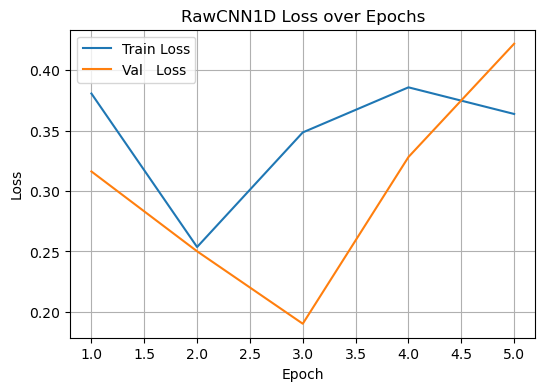

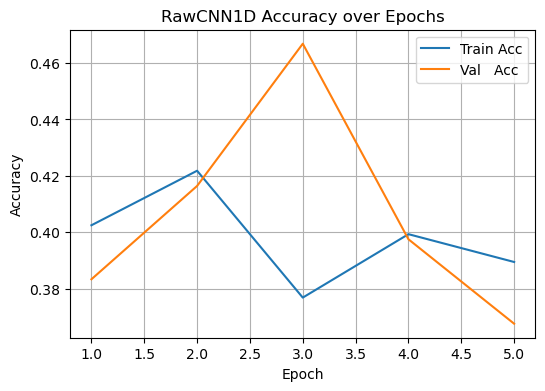

NameError: name 'mel_hist' is not defined

In [20]:
# For your raw‐waveform CNN
plot_training_curves(raw_hist, model_name="RawCNN1D")

# For your Mel‐spectrogram CNN
plot_training_curves(mel_hist, model_name="MelCNN2D")

-----

## 1.2a: Raw input signal -> analyze as 1D signal -> standardize

In [28]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


# Splitting into train/val (80/20) with stratification on accent, so they each appear ~ in the same proportion in train/validation set
val_fraction = 0.2
df_train, df_val = train_test_split(
    df,
    test_size=val_fraction,
    random_state=42,
    stratify=df["accent"]
)
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)



max_length = 16000 * 5  # 5 seconds
batch_size = 32
num_workers = 4

# Raw waveform datasets and loaders
train_ds = AccentDataset(
    metadata_df=df_train,
    approach="raw",       # raw 1D signal
    max_length=max_length,
)
val_ds   = AccentDataset(
    metadata_df=df_val,
    approach="raw",
    max_length=max_length,
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)




## Raw models

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import classification_report
# import torch.nn as nn

# class RawCNN1D(nn.Module):
#     def __init__(self, num_classes=5, p_dropout=0.3):
#         super().__init__()
#         self.net = nn.Sequential(
#             # Conv + aggressive pooling to cut 80k → 5k → 1
#             nn.Conv1d(1, 32, kernel_size=9, padding=4), nn.ReLU(),
#             nn.MaxPool1d(4),  # 80k→20k
#             nn.Conv1d(32, 64, kernel_size=9, padding=4), nn.ReLU(),
#             nn.MaxPool1d(4),  # 20k→5k
#             nn.Conv1d(64, 128, kernel_size=9, padding=4), nn.ReLU(),
#             nn.AdaptiveAvgPool1d(1),  # 5k→1
#             nn.Flatten(),
#             nn.Dropout(p_dropout)
#         )
#         self.classifier = nn.Linear(128, num_classes)

#     def forward(self, x):
#         # x: [B,1,T]
#         feat = self.net(x)       # [B,128]
#         return self.classifier(feat)


# class MelCNN2D(nn.Module):
#     def __init__(self, num_classes=5, p_dropout=0.3):
#         super().__init__()
#         self.net = nn.Sequential(
#             # x: [B,1,n_mels,time]
#             nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
#             nn.MaxPool2d(2),  # n_mels/2 × time/2
#             nn.Conv2d(32,64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
#             nn.MaxPool2d(2),  # n_mels/4 × time/4
#             nn.Conv2d(64,128,kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1,1)), # collapse to [B,128,1,1]
#             nn.Flatten(),
#             nn.Dropout(p_dropout)
#         )
#         self.classifier = nn.Linear(128, num_classes)

#     def forward(self, x):
#         feat = self.net(x)  # [B,128]
#         return self.classifier(feat)



## Training models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
            # ← add this

# --- 1. Define RNN and LSTM models ---

class RawRNN1D(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2,
                 num_classes=5, p_dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=p_dropout,
            nonlinearity='tanh'
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p_dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)        # [B,1,T] → [B,T,1]
        rnn_out, h_n = self.rnn(x)
        last_h = h_n[-1]             # [B, hidden]
        return self.classifier(last_h)


class RawLSTM1D(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2,
                 num_classes=5, p_dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=p_dropout
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p_dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)        # [B,1,T] → [B,T,1]
        _, (h_n, _) = self.lstm(x)
        last_h = h_n[-1]             # [B, hidden]
        return self.classifier(last_h)


# --- 2. Instantiate, optimize, and train both models ---



criterion = nn.CrossEntropyLoss()

def run_experiment(model_cls, train_loader, val_loader, **model_kwargs):
    model = model_cls(**model_kwargs).to(device)
    optimizer = optim.Adam(
        model.parameters(),
        lr=1e-3,
        weight_decay=1e-4
    )

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, 11):
        # --- Training ---
        model.train()
        total_loss, correct, count = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), (y-1).to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            count += x.size(0)
        train_loss = total_loss / count
        train_acc = correct / count

        # --- Validation ---
        model.eval()
        total_loss, correct, count = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), (y-1).to(device)
                logits = model(x)
                loss = criterion(logits, y)
                total_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                count += x.size(0)
        val_loss = total_loss / count
        val_acc = correct / count

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{model.__class__.__name__} "
              f"Epoch {epoch:02d}  "
              f"Train: {train_loss:.3f}, {train_acc:.3f} | "
              f"Val: {val_loss:.3f}, {val_acc:.3f}")

    return model, history

# …then call run_experiment(RawRNN1D, …) and run_experiment(RawLSTM1D, …) as before.


In [30]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def run_experiment(model_cls, train_loader, val_loader, **model_kwargs):
    model = model_cls(**model_kwargs).to(device)
    optimizer = optim.Adam(
        model.parameters(),
        lr=1e-3,
        weight_decay=1e-4    # L2 regularization
    )

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, 11):
        # Train
        model.train()
        total_loss, correct, count = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), (y-1).to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds==y).sum().item()
            count   += x.size(0)
        train_loss = total_loss/count
        train_acc  = correct/count

        # Validate
        model.eval()
        total_loss, correct, count = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), (y-1).to(device)
                logits = model(x)
                loss = criterion(logits, y)
                total_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds==y).sum().item()
                count   += x.size(0)
        val_loss = total_loss/count
        val_acc  = correct/count

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{model.__class__.__name__} Epoch {epoch:02d}  "
              f"Train: {train_loss:.3f}, {train_acc:.3f} | "
              f"Val: {val_loss:.3f}, {val_acc:.3f}")

    return model, history

# Run on your DataLoaders (raw_loader defined earlier)
rnn_model, rnn_hist  = run_experiment(
    RawRNN1D, train_loader=raw_loader, val_loader=val_loader,
    input_size=1, hidden_size=128, num_layers=2, p_dropout=0.3, num_classes=5
)
lstm_model, lstm_hist = run_experiment(
    RawLSTM1D, train_loader=raw_loader, val_loader=val_loader,
    input_size=1, hidden_size=128, num_layers=2, p_dropout=0.3, num_classes=5
)


/Users/bramdewaal/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/bramdewaal/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bramdewaal/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'AccentDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 